## Simulation CLP - PID - FF

### Imports

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from package_DBR import myRound, SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode

import package_LAB
from importlib import reload
package_LAB = reload(package_LAB)
from package_LAB import LeadLag_RT, PID_RT, IMC_Tuning, Controller, Stability_Margins


### Simulation parameters

In [20]:

#Simulation
TSim = 2200
Ts = 1
N = int(TSim/Ts) + 1

#Working point
MV0 = 50
DV0 = 50
PV0 = 60.5

#Process
#-------
#Parameters for input-output dynamics
Kp = 0.35711258020523884
T1p = 140.00376928937064
T2p = 7.922782664796644
thetap = 7.3555801756095915

#Parameters for disturbance dynamics
Kd = 0.3412336672067159
T1d = 189.99702702740825
T2d = 21.759406076826345
thetad = 18.21683345312439

#Parameter PID controller
gamma = 1

#IMC tuning
#-----------
P = Process({})
P.parameters['Kp'] = Kp
P.parameters['Tlead1'] = 0
P.parameters['Tlag1'] = T1p
P.parameters['Tlag2'] = T2p
P.parameters['theta'] = thetap
P.parameters['nInt'] = 0

C = Controller({})
IMC_Tuning(P,C,gamma)
Kc = C.parameters['Kc']
Ti = C.parameters['Ti']
Td = C.parameters['Td']

print('IMC_Tuning')
print('Kc:', Kc)
print('Ti:', Ti)
print('Td:', Td)


alpha = 1
MVMin = 0
MVMax = 100

IMC_Tuning
Kc: 3.470461928975884
Ti: 147.92655195416728
Td: 7.498447179892956


### Simulation input signals

In [21]:
#simulation input signals
simulation= 2

if simulation == 1:
    # Scenario 1: OLP + no FF
    ManPath = {0: True, TSim: True}
    MVManPath = {0: MV0, TSim: MV0}
    SPPath = {0: PV0, TSim :PV0}
    DVPath = {0: 50.0, 1000: 60, TSim: 60.0}
    ActivateFF = False
    ManFF = True
    Title_loop = "Open-Loop"
    Title_FF = "No FeedForward"

elif simulation == 2:
    # Scenario 2: OLP + FF
    ManPath = {0: True, TSim: True}
    MVManPath = {0: MV0, TSim: MV0}
    SPPath = {0: PV0, TSim :PV0}
    DVPath = {0: 50.0, 1000: 60, TSim: 60.0}
    ActivateFF = True
    ManFF = True
    Title_loop = "Open-Loop"
    Title_FF = "FeedForward"

elif simulation == 3:
    # Scenario 3: CLP + no FF
    ManPath = {0: True, 500: False, TSim: False}
    MVManPath = {0: MV0+15, TSim: MV0+15}
    SPPath = {0: PV0+5, 1000: PV0-5, TSim :PV0-5}
    DVPath = {0: DV0, 1600: DV0+10, TSim: DV0+10}
    ActivateFF = False
    ManFF = False 
    Title_loop = "Closed-Loop"
    Title_FF = "No FeedForward"

elif simulation == 4:
    #Scenario 4 : CLP + FF
    ManPath = {0:True, 500:False, TSim: False}
    MVManPath = {0:MV0+15, TSim:MV0+15}
    SPPath = {0:PV0+5, 1000: PV0-5, TSim: PV0-5}
    DVPath = {0:DV0, 1800: DV0+10, TSim: DV0+10}
    ActivateFF = True
    ManFF = False 
    Title_loop = "Closed-Loop"
    Title_FF = "FeedForward"

else :
    ManPath = {0:True, 500:False, TSim: False}
    MVManPath = {0:MV0+15, TSim:MV0+15}
    SPPath = {0:PV0+5, 1000: PV0-5, TSim: PV0-5}
    DVPath = {0:DV0, 1800: DV0+10, TSim: DV0+10}
    ActivateFF = True
    ManFF = False 
    Title_loop = "Closed-Loop"
    Title_FF = "FeedForward"

### Closed-loop simulation with PID and FF

In [22]:
t = []
SP = []
MV = []
PV = []
DV =[]
Man = []
MVMan = []
MVFF = []
MVP = []
MVI = []
MVD = [] 
E  = []
EP = []
ED = []

MVFFDelay = []
MVFFLL1 = []

MVDelayp = []
PV1p = []
PV2p = []

MVDelayd = []
PV1d = []
PV2d = []


for i in range(0, N):
    t.append(i*Ts)
    
    #input signal SP and DV
    SelectPath_RT(SPPath,t,SP)
    SelectPath_RT(DVPath,t,DV)
    
    #Feedforward
    Delay_RT(DV - DV0*np.ones_like(DV),np.max([thetad-thetap,0]),Ts,MVFFDelay)
    LeadLag_RT(MVFFDelay, -Kd/Kp, T1p,T1d,Ts,MVFFLL1)
    if ActivateFF:
        LeadLag_RT(MVFFLL1, 1, T2p,T2d,Ts,MVFF)
    else:
        LeadLag_RT(MVFFLL1, 0, T2p,T2d,Ts,MVFF)
        
    #PID controller mode
    SelectPath_RT(ManPath,t,Man)
    SelectPath_RT(MVManPath,t,MVMan)
    
    #PID control action
    PID_RT(SP,PV,Man,MVMan,MVFF,Kc,Ti,Td,alpha,Ts,MVMin,MVMax,MV,MVP,MVI,MVD,E,ManFF,PV0,method='EBD-EBD')
    
    #Input-output dynamics P(s)
    Delay_RT(MV,thetap,Ts,MVDelayp,MV0)
    FO_RT(MVDelayp,Kp,T1p,Ts,PV1p,0)
    FO_RT(PV1p,1,T2p,Ts,PV2p,0)
    
    #Disturbance dynamics D(s)
    Delay_RT(DV - DV0*np.ones_like(DV),thetad,Ts,MVDelayd,0)
    FO_RT(MVDelayd,Kd,T1d,Ts,PV1d,0)
    FO_RT(PV1d,1,T2d,Ts,PV2d,0)
    
    PV.append(PV2p[-1] + PV2d[-1] + PV0-Kp*MV0)

### Plots

(0.0, 2200.0)

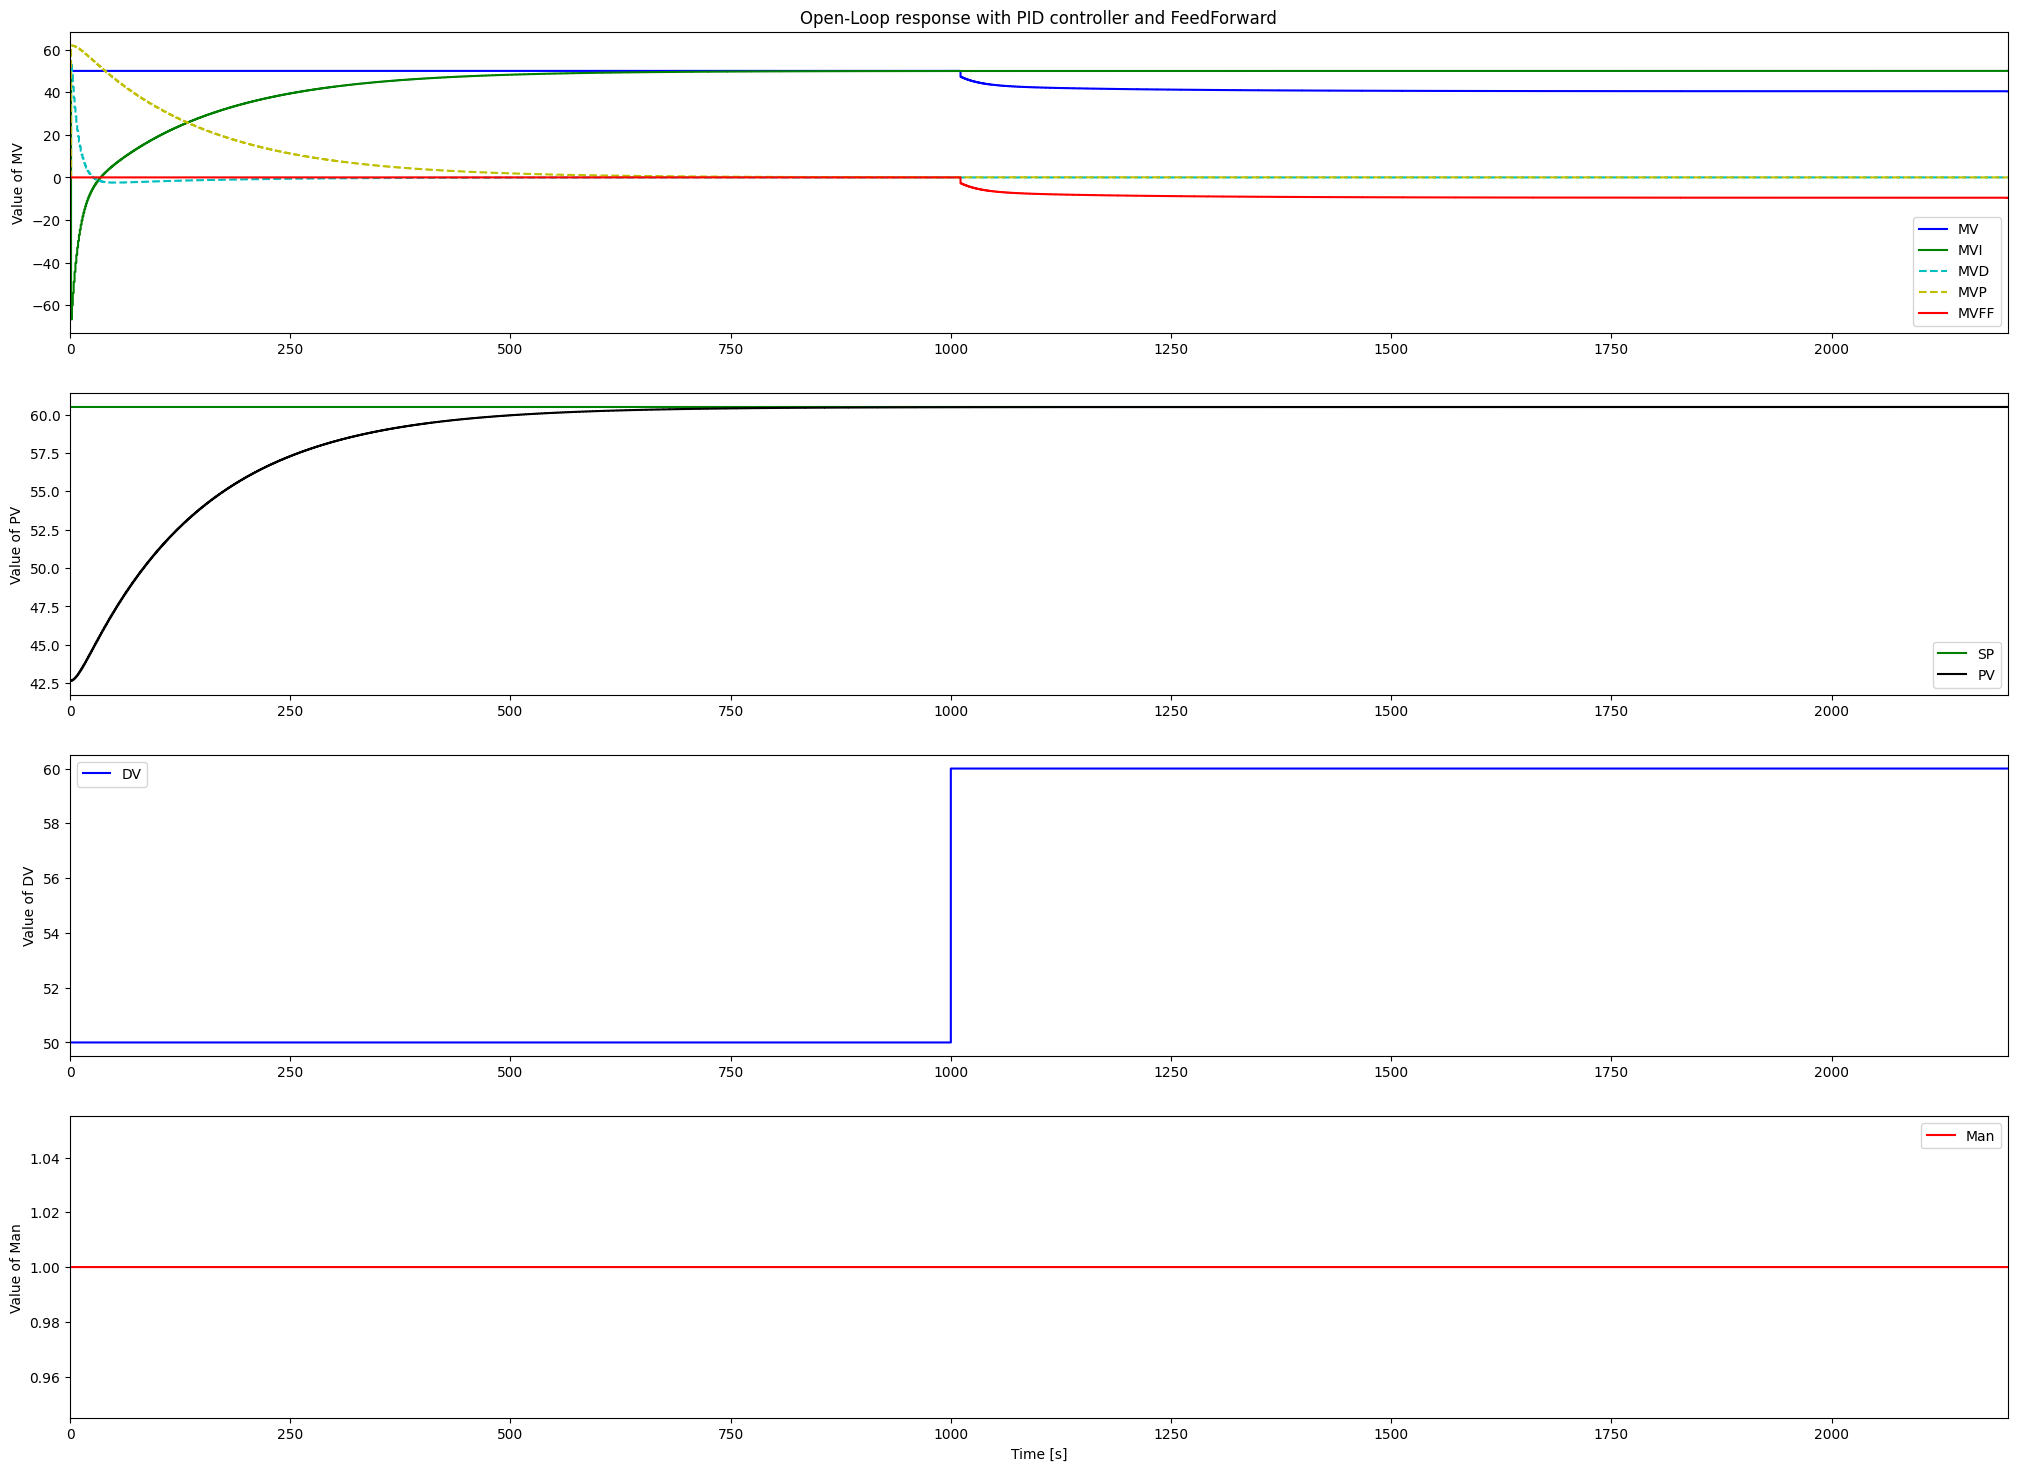

In [23]:
plt.figure(figsize = (25,18))

plt.subplot(4,1,1)
plt.step(t,MV,'b-',label='MV',where='post')
plt.step(t,MVI,'g-',label='MVI',where='post')
plt.step(t,MVD,'c--',label='MVD',where='post')
plt.step(t,MVP,'y--',label='MVP',where='post')
plt.step(t,MVFF,'r-',label='MVFF',where='post')
plt.ylabel('Value of MV')
plt.title(Title_loop + ' response with PID controller and ' + Title_FF)
plt.legend(loc='best')
plt.xlim([0, TSim])

plt.subplot(4,1,4)
plt.step(t,Man,'r-',label='Man',where='post')
plt.ylabel('Value of Man')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.xlim([0, TSim])

plt.subplot(4,1,3)
plt.step(t,DV,'b-',label='DV',where='post')
plt.ylabel('Value of DV')
plt.legend(loc='best')
plt.xlim([0, TSim])    


plt.subplot(4,1,2)
plt.step(t,SP,'g-',label='SP',where='post')
plt.step(t,PV,'black',label='PV',where='post')
plt.ylabel('Value of PV')
plt.legend(loc='best')
plt.xlim([0, TSim])   

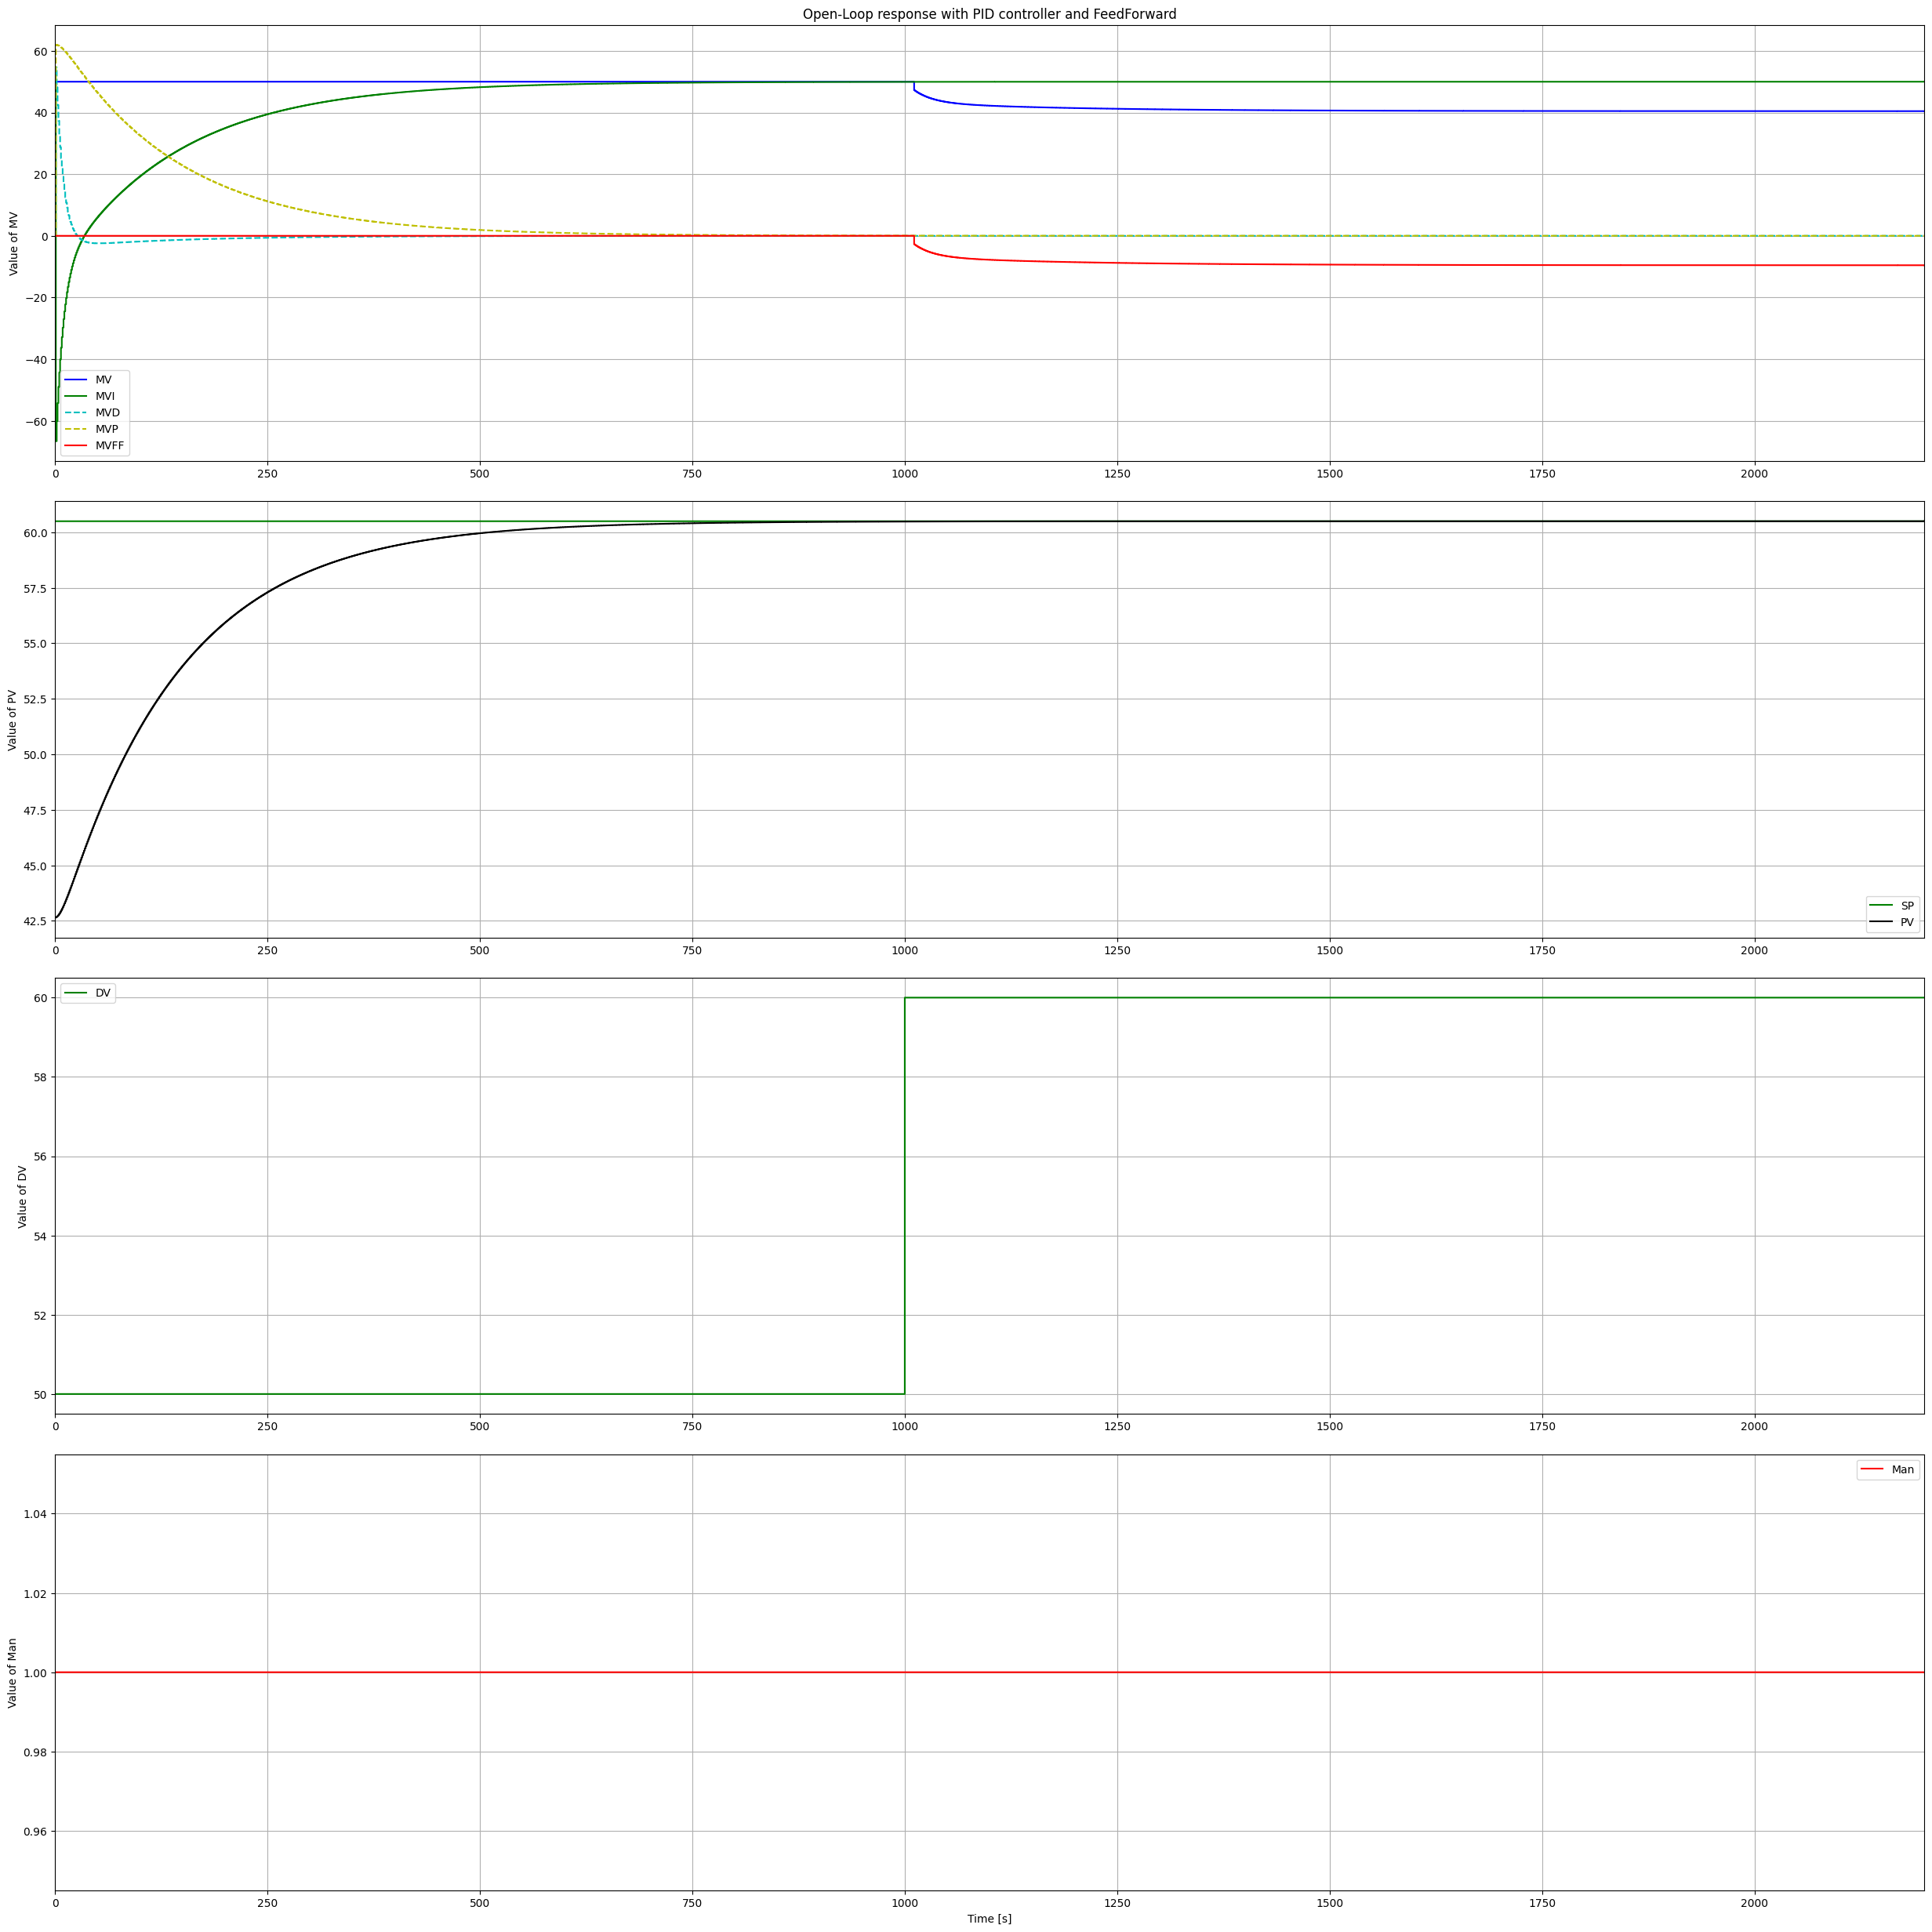

In [24]:
# Create figure upfront
fig, ((ax1), (ax2), (ax3), (ax4)) = plt.subplots(4, 1)
fig.set_figheight(25)
fig.set_figwidth(25)

# Plot data
l1, = ax1.step(t, MV, 'b-', label='MV', where='post')
l1, = ax1.step(t, MVI, 'g-', label='MVI', where='post')
l1, = ax1.step(t, MVD, 'c--', label='MVD', where='post')
l1, = ax1.step(t, MVP, 'y--', label='MVP', where='post')
l1, = ax1.step(t, MVFF, 'r-', label='MVFF', where='post')
ax1.set_ylabel('Value of MV')
ax1.set_title(Title_loop + ' response with PID controller and ' + Title_FF)
ax1.legend(loc='best')
ax1.set_xlim([0, TSim])
ax1.grid()

l2, = ax2.step(t, SP, 'g-', label='SP', where='post')
l2, = ax2.step(t, PV, 'black', label='PV', where='post')
ax2.set_ylabel('Value of PV')
ax2.legend(loc='best')
ax2.set_xlim([0, TSim])
ax2.grid()

l3, = ax3.step(t, DV, 'g-', label='DV', where='post')
ax3.set_ylabel('Value of DV')
ax3.legend(loc='best')
ax3.set_xlim([0, TSim])
ax3.grid()

l4, = ax4.step(t, Man, 'r-', label='Man', where='post')
ax4.set_ylabel('Value of Man')
ax4.set_xlabel('Time [s]')
ax4.legend(loc='best')
ax4.set_xlim([0, TSim])
ax4.grid()

plt.tight_layout(pad=2.0)
plt.show()
